In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import pandas as pd
import seaborn as sns

import copy
import time

from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\ayxan\AppData\Local\Temp\ipykernel_21224\4007184922.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# gpu activate

In [30]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# data preparing

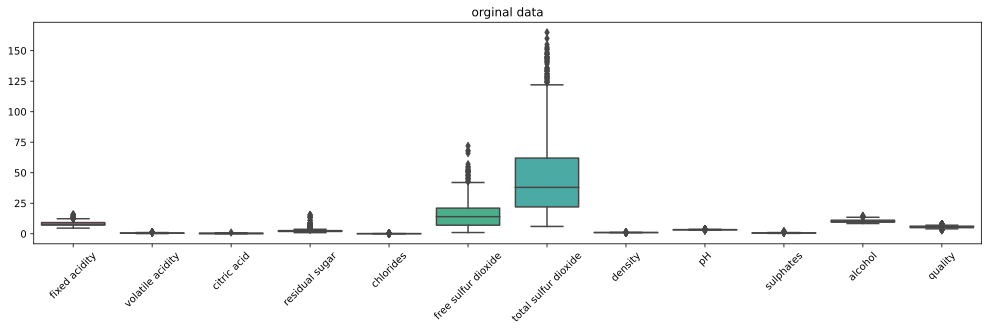

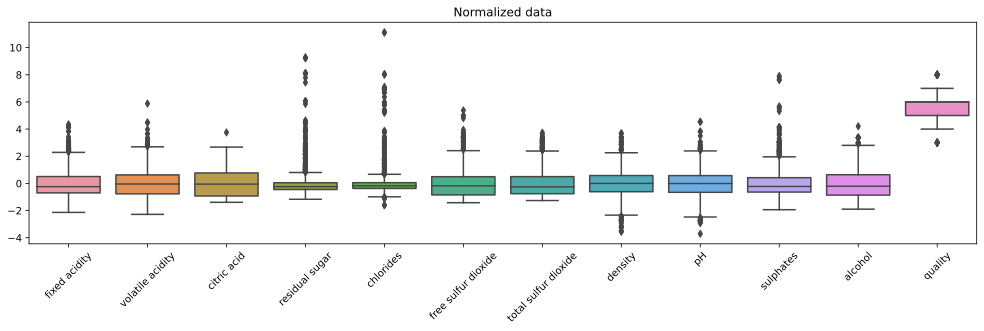

In [2]:
#data loading 
data=pd.read_csv('winequality-red .csv',sep=';')
data=data[data['total sulfur dioxide']<200]
fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('orginal data')

#data normaliztion
colsNorm=data.keys()
colsNorm=colsNorm.drop('quality')
data[colsNorm]=data[colsNorm].apply(stats.zscore)
fig,ax=plt.subplots(1,figsize=(17,4))
ax=sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('Normalized data')
plt.show()

# preparing data for training

In [244]:
data['boolQuality']=0
data['boolQuality']=(data['quality']>5).astype(int)

output={} #that contain train, devset, test data set

dataTensor=torch.tensor(data[colsNorm].values).float()
labelTensor=torch.tensor(data['boolQuality'].values).float()
labelTensor=labelTensor[:,None]

train_data,devtest_data,train_label,devtest_label=train_test_split(\
                                dataTensor,labelTensor,train_size=0.8)

test_data,devset_data,test_label,devset_label=train_test_split(\
                                devtest_data,devtest_label,train_size=0.5)

train_dataset=TensorDataset(train_data,train_label)
devset_dataset=TensorDataset(devset_data,devset_label)
test_dataset=TensorDataset(test_data,test_label)

output['train_loader']=DataLoader(train_dataset,batch_size=32,shuffle=True,drop_last=True)
output['devset_loader']=DataLoader(devset_dataset,batch_size=devset_dataset.tensors[0].shape[0])
output['test_loader']=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])


# ann preparing

In [144]:
def createModel():
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input=nn.Linear(11,32)
            
            self.fc1=nn.Linear(32,64)
            self.bNorm1=nn.BatchNorm1d(32)
            
            self.fc2=nn.Linear(64,64)
            self.bNorm2=nn.BatchNorm1d(64)
            
            self.fc3=nn.Linear(64,32)
            self.bNorm3=nn.BatchNorm1d(64)
            
#             self.fc4=nn.Linear(32,32)
#             self.bNorm4=nn.BatchNorm1d(32)
            
            self.output=nn.Linear(32,1)
        
        def forward(self,x):
            x=F.relu(self.input(x))
            
            x=self.bNorm1(x)
            x=F.relu(self.fc1(x))
            
            x=self.bNorm2(x)
            x=F.relu(self.fc2(x))
            
            x=self.bNorm3(x)
            x=F.relu(self.fc3(x))
            
#             x=self.bNorm4(x)
#             x=F.relu(self.fc4(x))
            
            return self.output(x)

    ANN=Model()
    
    lossfun=nn.BCEWithLogitsLoss()
    
    optimizer=torch.optim.Adam(ANN.parameters(),lr=0.001)
    
    return ANN,lossfun,optimizer            

In [103]:
def trainModel(Numepoch=20):
      
    losses=torch.zeros(Numepoch)
    trainAcc=[]
    devsetAcc=[]
    
    completedTime=time.process_time()
    
    ANN,lossfun,optimizer=createModel()
    
    theBestModel={'Accuracy':0,'ANN':None}
    
    for epoch in range(Numepoch):
        
        startTime=time.process_time()
        
        batchAcc=[]
        batchloss=[]
        
        ANN.train()
        ANN.to(device)
        for dat,lab in output['train_loader']:
            
            dat=dat.to(device)
            lab=lab.to(device)
            
            yHat=ANN(dat)
            loss=lossfun(yHat,lab)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchloss.append(loss.item())
            
            yHat=yHat.cpu()
            lab=lab.cpu()
            
            match=((yHat>0)==lab).float()
            batchAcc.append(100*torch.mean(match))
        
        trainAcc.append(np.mean(batchAcc))
        losses[epoch]=np.mean(batchloss)

        ANN.eval()
        
        dat,lab=next(iter(output['devset_loader']))
        dat=dat.to(device)
        
        with torch.no_grad():
            yHat=ANN(dat)
        
        yHat=yHat.cpu()
        devsetAcc.append(100*torch.mean(((yHat>0)==lab).float()))
        
        if devsetAcc[-1]>theBestModel['Accuracy']:
            theBestModel['Accuracy']=devsetAcc[-1].item()
            theBestModel['ANN']=copy.deepcopy( ANN.state_dict() )
        
        processTime=time.process_time()-startTime
#         print(f'{epoch+1}-th trainAcc:{trainAcc[epoch]},----devsetAcc{devsetAcc[epoch]},----lossValue:{losses[epoch]},---CompTime {processTime:.2f}-sec')
        
    completedTime=time.process_time()-completedTime
    return theBestModel,trainAcc,devsetAcc,losses,completedTime,ANN

training complete is:33.734375 time


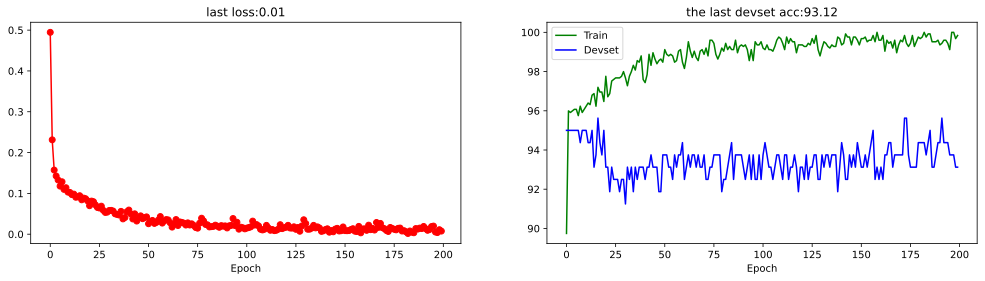

In [239]:
theBestModel,trainAcc,devsetAcc,losses,completedTime,ANN=trainModel(200)
print(f'training complete is:{completedTime} time')
fig,ax=plt.subplots(1,2,figsize=(17,4))
ax[0].plot(losses,'ro-')
ax[0].set_title(f'last loss:{losses[-1]:.2f}')
ax[0].set_xlabel('Epoch')

ax[1].plot(trainAcc,'g-',label=('Train'))
ax[1].plot(devsetAcc,'b-',label=('Devset'))
ax[1].set_title(f'the last devset acc:{devsetAcc[-1]:.2f}')
ax[1].set_xlabel('Epoch')
ax[1].legend()

In [272]:
dat,lab=next(iter(output['test_loader']))
bestnetwork=createModel()[0]
bestnetwork.load_state_dict(theBestModel['ANN'])

prediction=bestnetwork(dat)
accuracy=((prediction>0)==lab).float()
acc=100*torch.mean(accuracy)
acc

tensor(56.2500)

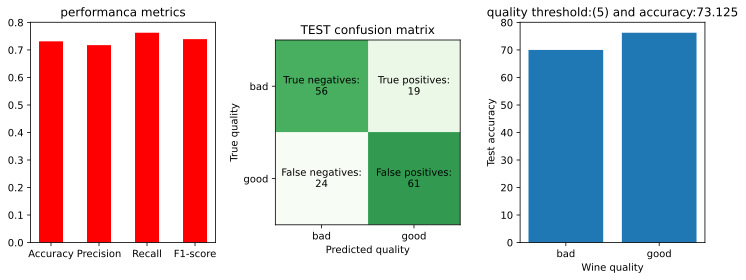

In [237]:
import sklearn.metrics as skm

Qualityset=[100*torch.mean(accuracy[lab==0]),\
            100*torch.mean(accuracy[lab==1])]

test_metrics=[0,0,0,0]

test_metrics[0]=skm.accuracy_score(output['test_loader'].dataset.tensors[1],\
                                   prediction>0)
test_metrics[1]=skm.precision_score(output['test_loader'].dataset.tensors[1],\
                                    prediction>0)
test_metrics[2]=skm.recall_score(output['test_loader'].dataset.tensors[1],\
                                    prediction>0)
test_metrics[3]=skm.f1_score(output['test_loader'].dataset.tensors[1],\
                                    prediction>0)

fig,ax=plt.subplots(1,3,figsize=(10,4))
ax[0].bar(np.arange(4),test_metrics,0.5,color='red')
ax[0].set_xticks(np.arange(4),['Accuracy','Precision','Recall','F1-score'])
ax[0].set_title('performanca metrics')

testconf=skm.confusion_matrix(output['test_loader'].dataset.tensors[1],\
                                    prediction>0)

ax[1].imshow(testconf,'Greens',vmax=len(prediction)/2)
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['bad','good'])
ax[1].set_yticks([0,1])
ax[1].set_yticklabels(['bad','good'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('TEST confusion matrix')

ax[1].text(0,0,f'True negatives:\n{testconf[0,0]}',ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{testconf[0,1]}',ha='center',va='center')
ax[1].text(1,0,f'True positives:\n{testconf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'False positives:\n{testconf[1,1]}',ha='center',va='center')

ax[2].bar(['bad','good'],Qualityset)
ax[2].set_xlabel('Wine quality')
ax[2].set_ylabel('Test accuracy') 
ax[2].set_title(f'quality threshold:(5) and accuracy:{acc}')

plt.tight_layout()
plt.show()

In [ ]:
S